<a href="https://colab.research.google.com/github/Leena811/civic_eye/blob/main/final_civic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1.1 Enable GPU: Runtime -> Change runtime type -> GPU
# 1.2 Run this cell to mount Drive and check GPU + TF
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
DATA_DIR = '/content/drive/MyDrive/civic_eye_dataset_new'
# The four folders (exact names you provided):
classes = ['garbage_images','Potholes_images','Sewage_drainage_images','street_light_images']


In [ ]:
import os, glob
for c in classes:
    files = []
    for ext in ('*.jpg','*.jpeg','*.png'):
        files += glob.glob(os.path.join(DATA_DIR, c, ext))
    print(f"{c}: {len(files)} images")


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import glob

filepaths = []
labels = []
for idx, c in enumerate(classes):
    for ext in ('*.jpg','*.jpeg','*.png'):
        for f in glob.glob(os.path.join(DATA_DIR, c, ext)):
            filepaths.append(f)
            labels.append(idx)

filepaths = np.array(filepaths)
labels = np.array(labels)

# 70% train, 30% temp -> then split temp into val & test (50/50 -> 15% each)
X_train, X_temp, y_train, y_temp = train_test_split(
    filepaths, labels, stratify=labels, test_size=0.30, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=42)

print("train, val, test sizes:", len(X_train), len(X_val), len(X_test))



In [ ]:
import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = (224, 224)     # works well with EfficientNetB0
BATCH_SIZE = 32

# augmentation (used only for training)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.12),
    tf.keras.layers.RandomZoom(0.12),
    tf.keras.layers.RandomContrast(0.08),
])

def decode_resize(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)  # handles jpg/jpeg/png
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32)
    return image

# EfficientNet expects its preprocess_input (scales as needed)
preprocess = tf.keras.applications.efficientnet.preprocess_input

def process_train(path, label):
    image = decode_resize(path)
    image = data_augmentation(image)
    image = preprocess(image)   # now it's ready for the pretrained model
    return image, label

def process_eval(path, label):
    image = decode_resize(path)
    image = preprocess(image)
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = (train_ds.shuffle(len(X_train))
                    .map(lambda x,y: process_train(x,y), num_parallel_calls=AUTOTUNE)
                    .batch(BATCH_SIZE)
                    .prefetch(AUTOTUNE))

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).map(process_eval, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(process_eval, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)


In [ ]:
from sklearn.utils import class_weight
class_weights_arr = class_weight.compute_class_weight('balanced',
                                                     classes=np.unique(y_train),
                                                     y=y_train)
class_weights = {i: w for i, w in enumerate(class_weights_arr)}
print("class_weights:", class_weights)


In [ ]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False, weights='imagenet', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False   # freeze for head training

inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(len(classes), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


In [16]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/civic_eye_model_best.keras',
                                       save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
]

initial_epochs = 10
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    class_weight=class_weights,
                    callbacks=callbacks)



Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 132s 5s/step - accuracy: 0.3928 - loss: 1.2935 - val_accuracy: 0.8800 - val_loss: 0.5722 - learning_rate: 0.0010
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.8605 - loss: 0.5779 - val_accuracy: 0.9667 - val_loss: 0.2894 - learning_rate: 0.0010
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - accuracy: 0.9444 - loss: 0.3236 - val_accuracy: 0.9733 - val_loss: 0.1975 - learning_rate: 0.0010
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.9478 - loss: 0.2605 - val_accuracy: 0.9800 - val_loss: 0.1533 - learning_rate: 0.0010
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.9513 - loss: 0.2303 - val_accuracy: 0.9867 - val_loss: 0.1256 - learning_rate: 0.0010
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.9681 - loss: 0.1849 - val_accuracy: 0.9867 - val_loss: 0.1100 - learning_rate: 0.0010
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.9737 - loss: 0.1617 - val_accuracy

In [17]:
# Unfreeze last N layers of base_model for fine-tuning
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 30  # you can experiment with this number
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_epochs = 15
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                         class_weight=class_weights,
                         callbacks=callbacks)


Epoch 10/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.9380 - loss: 0.3314 - val_accuracy: 0.9867 - val_loss: 0.0762 - learning_rate: 1.0000e-05
Epoch 11/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 129s 4s/step - accuracy: 0.9312 - loss: 0.3309 - val_accuracy: 0.9933 - val_loss: 0.0821 - learning_rate: 1.0000e-05
Epoch 12/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 131s 4s/step - accuracy: 0.9166 - loss: 0.3297 - val_accuracy: 0.9933 - val_loss: 0.0875 - learning_rate: 1.0000e-05
Epoch 13/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - accuracy: 0.9304 - loss: 0.3053 - val_accuracy: 0.9933 - val_loss: 0.0917 - learning_rate: 1.0000e-05
Epoch 14/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 150s 4s/step - accuracy: 0.9455 - loss: 0.2762 - val_accuracy: 0.9933 - val_loss: 0.0985 - learning_rate: 5.0000e-06
Epoch 15/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - accuracy: 0.9319 - loss: 0.2858 - val_accuracy: 0.9933 - val_loss: 0.1040 - learning_rate: 5.0000e-06


In [18]:
# 9.1 model.evaluate
loss, acc = model.evaluate(test_ds)
print("Test loss:", loss, "Test accuracy:", acc)

# 9.2 predictions -> classification report + confusion matrix
import numpy as np
y_true = np.concatenate([y.numpy() for x,y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, target_names=classes))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))


5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9791 - loss: 0.1143
Test loss: 0.10206879675388336 Test accuracy: 0.9867549538612366
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step
                        precision    recall  f1-score   support

        garbage_images       1.00      1.00      1.00        41
       Potholes_images       1.00      0.95      0.97        37
Sewage_drainage_images       0.94      1.00      0.97        34
   street_light_images       1.00      1.00      1.00        39

              accuracy                           0.99       151
             macro avg       0.99      0.99      0.99       151
          weighted avg       0.99      0.99      0.99       151

Confusion matrix:
 [[41  0  0  0]
 [ 0 35  2  0]
 [ 0  0 34  0]
 [ 0  0  0 39]]


In [19]:
# ✅ Save model in .keras format
model_save_path = '/content/drive/MyDrive/civic_eye_model_final.keras'
model.save(model_save_path)
print("Saved model to:", model_save_path)

# (Optional) if you also want .h5
# model.save('/content/drive/MyDrive/civic_eye_model_final.h5')


Saved model to: /content/drive/MyDrive/civic_eye_model_final.keras


In [24]:
from google.colab import files
from PIL import Image
import numpy as np
import tensorflow as tf

# ✅ Upload image(s) using file picker
uploaded = files.upload()

# Mapping labels -> folder -> department
label_to_folder = {i: classes[i] for i in range(len(classes))}
label_to_department = {
    'garbage_images': 'Department of sanitation',
    'potholes_images': 'Department of Road and transport',
    'sewage_drainage_images': 'Department of sewage and drainage',
    'street_light_images': 'Department of street light'
}

def predict_image(path):
    img = Image.open(path).convert('RGB').resize(IMG_SIZE)
    arr = np.array(img).astype(np.float32)
    arr = tf.keras.applications.efficientnet.preprocess_input(arr)
    arr = np.expand_dims(arr, 0)

    probs = model.predict(arr)[0]
    idx = int(np.argmax(probs))
    folder_name = label_to_folder[idx]
    # Handle potential case mismatch or missing key
    dept = label_to_department.get(folder_name.lower(), 'Unknown Department')
    return {
        'pred_label': folder_name,
        'department': dept,
        'probability': float(probs[idx])
    }

# ✅ Run prediction for each uploaded file
for fn in uploaded.keys():
    result = predict_image(fn)
    print(f"\n📷 File: {fn}")
    print(f"Predicted Class: {result['pred_label']}")
    print(f"Department: {result['department']}")
    print(f"Confidence: {result['probability']*100:.2f}%")


Saving 9_jpg.rf.159030be6d8afa78dd7a6730d812ee84.jpg to 9_jpg.rf.159030be6d8afa78dd7a6730d812ee84.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step

📷 File: 9_jpg.rf.159030be6d8afa78dd7a6730d812ee84.jpg
Predicted Class: Sewage_drainage_images
Department: Department of sewage and drainage
Confidence: 98.77%


Step 1 : COMPLETED (Image Classification)




Step 2 : SETTING THE PRIORITY/SEVERITY

In [25]:
import os

# Path where you saved your model
model_save_path = '/content/drive/MyDrive/civic_eye_model_final.keras'

# Check if file exists
if os.path.exists(model_save_path):
    print("✅ Model file exists:", model_save_path)
    print("File size (MB):", round(os.path.getsize(model_save_path) / (1024*1024), 2))
else:
    print("❌ Model file not found at:", model_save_path)


✅ Model file exists: /content/drive/MyDrive/civic_eye_model_final.keras
File size (MB): 27.75


In [26]:
import os, datetime, numpy as np
from collections import defaultdict
PRIORITY_DATA_DIR = DATA_DIR  # You can point this to any folder you want to score
IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp", ".JPG", ".JPEG", ".PNG", ".WEBP"}
DEPT_CAPACITY = {
    'Department of sanitation': 1.2,
    'Department of Road and transport': 0.8,
    'Department of sewage and drainage': 0.9,
    'Department of street light': 1.1
}

_FALLBACK_DEPT = {
    'garbage_images': 'Department of sanitation',
    'Potholes_images': 'Department of Road and transport',
    'potholes_images': 'Department of Road and transport',
    'Sewage_drainage_images': 'Department of sewage and drainage',
    'sewage_drainage_images': 'Department of sewage and drainage',
    'street_light_images': 'Department of street light',
}
def _dept_for_label(lbl: str) -> str:
    try:
        return label_to_department.get(lbl, _FALLBACK_DEPT.get(lbl, 'Department of sanitation'))
    except NameError:
        return _FALLBACK_DEPT.get(lbl, 'Department of sanitation')
def _file_timestamp(path: str) -> datetime.datetime:
    try:
        return datetime.datetime.fromtimestamp(os.path.getmtime(path))
    except Exception:
        return datetime.datetime.now()
def _frequency_score(class_count: int, max_count: int) -> float:
    if max_count <= 0:
        return 0.0
    norm = class_count / float(max_count)            # 0..1
    score = np.log1p(norm * 10.0) / np.log1p(10.0) * 10.0
    return float(np.clip(score, 0.0, 10.0))

def _recency_score(timestamps) -> float:
    if not timestamps:
        return 0.0
    now = datetime.datetime.now()
    hours = [(now - ts).total_seconds() / 3600.0 for ts in timestamps if ts is not None]
    if not hours:
        return 0.0
    avg_hours = float(np.mean(hours))
    if avg_hours <= 1:   return 10.0
    if avg_hours <= 6:   return 8.0
    if avg_hours <= 24:  return 6.0
    if avg_hours <= 72:  return 4.0
    return 2.0

try:
    import cv2
except Exception as e:
    raise ImportError("OpenCV (cv2) is required for severity analysis. In Colab it's preinstalled. If local, install `opencv-python-headless`.") from e
class PrioritySeverityAnalyzer:
    """Rule-based severity scoring per image (0..10)."""
    def __init__(self):
        # Use normalized keys (lowercase) internally
        self.weights = {
            'garbage_images':             {'area_coverage': 0.4, 'color_intensity': 0.3, 'texture_roughness': 0.3},
            'potholes_images':            {'depth_estimation': 0.5, 'area_coverage': 0.3, 'edge_sharpness': 0.2},
            'sewage_drainage_images':     {'water_level': 0.4, 'contamination_color': 0.4, 'area_coverage': 0.2},
            'street_light_images':        {'darkness_level': 0.6, 'time_factor': 0.4},
        }

    def _norm_type(self, t: str) -> str:
        t = (t or "").strip()
        if t.lower().startswith("potholes_"): return "potholes_images"
        if t.lower().startswith("sewage_"):   return "sewage_drainage_images"
        return t.lower()

    def _safe_imread(self, path):
        img = cv2.imread(path)
        return img

    def analyze(self, issue_type: str, image_path: str, timestamp: datetime.datetime = None) -> float:
        key = self._norm_type(issue_type)
        if key == "garbage_images":
            return self._garbage(image_path)
        elif key == "potholes_images":
            return self._pothole(image_path)
        elif key == "sewage_drainage_images":
            return self._sewage(image_path)
        elif key == "street_light_images":
            return self._streetlight(image_path, timestamp)
        return 5.0

    def _garbage(self, path: str) -> float:
        img = self._safe_imread(path)
        if img is None: return 5.0
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # browns / dark-grays
        ranges = [
            ((10, 50, 20), (20, 255, 200)),    # brownish
            ((0, 0, 0), (180, 50, 100)),       # dark/gray
        ]
        total = 0
        for lo, hi in ranges:
            mask = cv2.inRange(hsv, np.array(lo), np.array(hi))
            total += cv2.countNonZero(mask)
        area_cov = total / float(img.shape[0] * img.shape[1])

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        color_var = float(np.var(gray))
        color_intensity = min(color_var / 1000.0, 1.0)

        edges = cv2.Canny(gray, 50, 150)
        tex_rough = float(np.sum(edges)) / (img.shape[0] * img.shape[1] * 255.0)

        w = self.weights['garbage_images']
        score = area_cov * w['area_coverage'] + color_intensity * w['color_intensity'] + tex_rough * w['texture_roughness']
        return float(np.clip(score * 10.0, 0.0, 10.0))

    def _pothole(self, path: str) -> float:
        img = self._safe_imread(path)
        if img is None: return 5.0
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 30, 100)
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours: return 1.0

        largest = max(contours, key=cv2.contourArea)
        area = float(cv2.contourArea(largest))
        area_cov = area / float(img.shape[0] * img.shape[1])

        blur = cv2.GaussianBlur(gray, (15, 15), 0)
        _, otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        # darker = deeper (rough proxy)
        depth_est = 1.0 - (np.sum(otsu) / (img.shape[0] * img.shape[1] * 255.0))

        edge_sharp = float(np.sum(edges)) / (img.shape[0] * img.shape[1] * 255.0)

        w = self.weights['potholes_images']
        score = depth_est * w['depth_estimation'] + area_cov * w['area_coverage'] + edge_sharp * w['edge_sharpness']
        return float(np.clip(score * 15.0, 0.0, 10.0))

    def _sewage(self, path: str) -> float:
        img = self._safe_imread(path)
        if img is None: return 5.0
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        # water-ish
        water = cv2.inRange(hsv, np.array([100, 50, 20]), np.array([130, 255, 255]))
        water_level = cv2.countNonZero(water) / float(img.shape[0] * img.shape[1])

        # contamination (greens/yellows/reds)
        contam_ranges = [
            ((35, 40, 40), (85, 255, 255)),   # green/yellow
            ((0, 120, 70), (10, 255, 255)),   # reddish
        ]
        contam = 0
        for lo, hi in contam_ranges:
            mask = cv2.inRange(hsv, np.array(lo), np.array(hi))
            contam += cv2.countNonZero(mask)
        contam_color = contam / float(img.shape[0] * img.shape[1])

        area_cov = water_level + contam_color
        w = self.weights['sewage_drainage_images']
        score = water_level * w['water_level'] + contam_color * w['contamination_color'] + area_cov * w['area_coverage']
        return float(np.clip(score * 12.0, 0.0, 10.0))

    def _streetlight(self, path: str, timestamp: datetime.datetime = None) -> float:
        img = self._safe_imread(path)
        if img is None: return 5.0
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        avg_brightness = float(np.mean(gray)) / 255.0
        darkness = 1.0 - avg_brightness

        time_factor = 1.0
        ts = timestamp or datetime.datetime.now()
        h = ts.hour
        if (18 <= h <= 23) or (0 <= h <= 6):
            time_factor = 1.5
        elif 6 < h < 18:
            time_factor = 0.7

        w = self.weights['street_light_images']
        score = darkness * w['darkness_level'] + (time_factor - 1.0) * w['time_factor']
        return float(np.clip(score * 8.0, 0.0, 10.0))
def _list_all_images(base_dir: str):
    items = []
    for root, _, files in os.walk(base_dir):
        for fn in files:
            ext = os.path.splitext(fn)[1]
            if ext in IMAGE_EXTS:
                path = os.path.join(root, fn)
                items.append(path)
    return items
def run_priority_on_directory(base_dir: str = PRIORITY_DATA_DIR, use_model: bool = True):
    paths = _list_all_images(base_dir)
    if not paths:
        print(f"No images found under: {base_dir}")
        return []

    # 1) Classify each image using your model (predict_image) or, fallback to folder name
    predictions = []
    for p in paths:
        # fallback predicted label from folder (last subfolder under base)
        folder_guess = os.path.basename(os.path.dirname(p))
        if use_model:
            try:
                pred = predict_image(p)  # defined in YOUR code above
                pred_label = pred.get('pred_label', folder_guess)
                dept = pred.get('department', _dept_for_label(pred_label))
                prob = float(pred.get('probability', 1.0))
            except Exception:
                pred_label, dept, prob = folder_guess, _dept_for_label(folder_guess), 1.0
        else:
            pred_label, dept, prob = folder_guess, _dept_for_label(folder_guess), 1.0

        predictions.append({
            "image_path": p,
            "pred_label": pred_label,
            "department": dept,
            "probability": prob,
            "timestamp": _file_timestamp(p),
        })

    # 2) Severity per image
    analyzer = PrioritySeverityAnalyzer()
    for item in predictions:
        item["severity"] = analyzer.analyze(item["pred_label"], item["image_path"], item["timestamp"])

    # 3) Group by predicted class (since no location clustering)
    groups = defaultdict(list)
    for it in predictions:
        groups[it["pred_label"]].append(it)

    # 4) Compute priority per class
    results = []
    max_reports = max((len(v) for v in groups.values()), default=1)
    for label, items in groups.items():
        sev_vals = [it["severity"] for it in items]
        avg_sev = float(np.mean(sev_vals))
        max_sev = float(np.max(sev_vals))
        final_sev = max_sev if (max_sev - avg_sev) > 2.0 else avg_sev  # capture rare extreme cases

        freq = _frequency_score(len(items), max_reports)
        rec  = _recency_score([it["timestamp"] for it in items])

        # weights: Severity 60% + Frequency 25% + Recency 15%
        score = final_sev * 0.60 + freq * 0.25 + rec * 0.15

        # apply department capacity
        dept = items[0]["department"]
        cap = DEPT_CAPACITY.get(dept, 1.0)
        score *= cap

        # store
        results.append({
            "issue_type": label,
            "department": dept,
            "reports": len(items),
            "severity": round(final_sev, 1),
            "frequency": round(freq, 1),
            "recency": round(rec, 1),
            "priority_score": round(score, 2),
            "sample_images": [os.path.basename(it["image_path"]) for it in items[:3]],
        })

    # 5) Sort & print
    results.sort(key=lambda r: r["priority_score"], reverse=True)

    print("\n🏆 PRIORITY RANKING (by predicted class)")
    for i, r in enumerate(results, 1):
        urgency = "🔥 URGENT" if r["priority_score"] > 7 else ("⚡ MEDIUM" if r["priority_score"] > 5 else "📝 LOW")
        print(f"\n#{i} {urgency}  Score: {r['priority_score']}")
        print(f"   Type: {r['issue_type']}  | Dept: {r['department']}  | Reports: {r['reports']}")
        print(f"   Severity: {r['severity']}/10  | Frequency: {r['frequency']}/10  | Recency: {r['recency']}/10")
        if r["sample_images"]:
            print(f"   Samples: {', '.join(r['sample_images'])}")

    return results


Evaluation on the Test dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

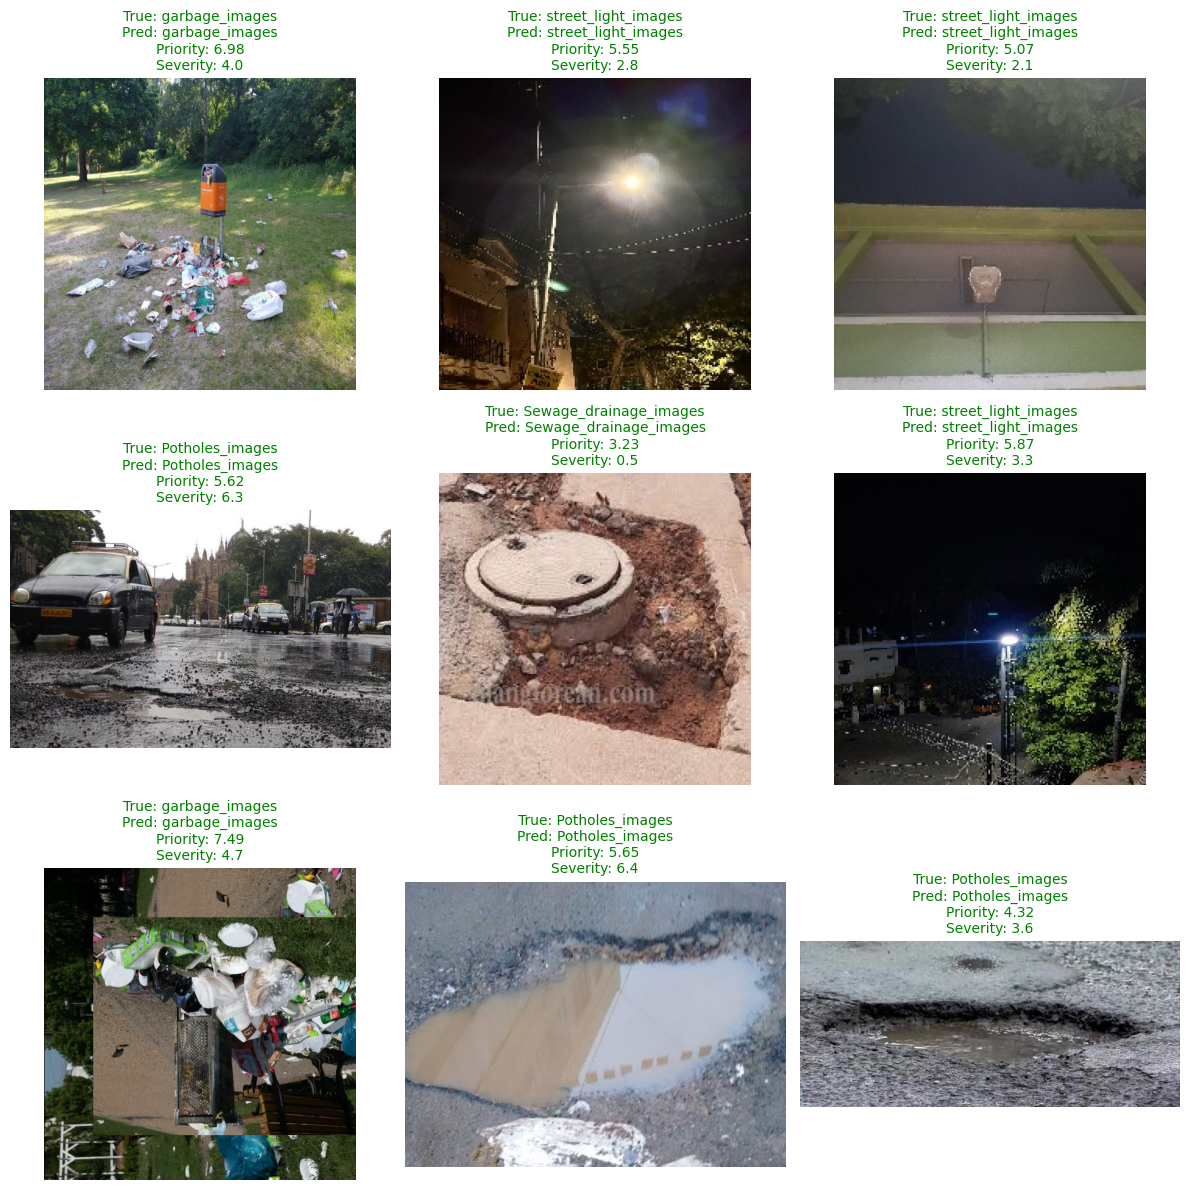

In [33]:
import os, datetime, numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image

# --- Helpers (reuse from your priority cell if already defined) ---
def file_timestamp(path: str) -> datetime.datetime:
    try:
        return datetime.datetime.fromtimestamp(os.path.getmtime(path))
    except Exception:
        return datetime.datetime.now()

def freq_score(count, max_count):
    if max_count <= 0: return 0.0
    norm = count / float(max_count)
    score = np.log1p(norm * 10.0) / np.log1p(10.0) * 10.0
    return float(np.clip(score, 0.0, 10.0))

def recency_score(timestamps):
    if not timestamps: return 0.0
    now = datetime.datetime.now()
    hours = [(now - ts).total_seconds()/3600.0 for ts in timestamps if ts is not None]
    if not hours: return 0.0
    avg = float(np.mean(hours))
    if avg <= 1:   return 10.0
    if avg <= 6:   return 8.0
    if avg <= 24:  return 6.0
    if avg <= 72:  return 4.0
    return 2.0

# --- Safe mapping between label strings and indices (handles case differences) ---
def label_str_to_idx(lbl: str):
    try:
        return classes.index(lbl)
    except ValueError:
        low = [c.lower() for c in classes]
        if lbl.lower() in low:
            return low.index(lbl.lower())
        # fallback: unknown -> 0
        return 0

# --- Main runner on X_test / y_test ---
def run_priority_on_test_set(show_grid=True, grid_n=9, apply_capacity=True):
    if 'X_test' not in globals() or 'y_test' not in globals():
        raise RuntimeError("X_test / y_test not found. Run your train/val/test split cell first.")
    if 'PrioritySeverityAnalyzer' not in globals():
        raise RuntimeError("PrioritySeverityAnalyzer not found. Paste the priority module first.")
    if 'predict_image' not in globals():
        raise RuntimeError("predict_image(...) not found. Keep your classification inference cell.")

    analyzer = PrioritySeverityAnalyzer()

    # 1) Per-image inference on test set
    pred_idx = []
    pred_label = []
    dept_list = []
    timestamps = []
    severities = []

    for p in X_test:
        ts = file_timestamp(p)
        pr = predict_image(p)  # uses your trained model
        lbl = pr.get('pred_label')
        dpt = pr.get('department', _FALLBACK_DEPT.get(lbl, 'Department of sanitation'))

        s = analyzer.analyze(lbl, p, ts)

        pred_label.append(lbl)
        pred_idx.append(label_str_to_idx(lbl))
        dept_list.append(dpt)
        timestamps.append(ts)
        severities.append(float(s))

    pred_idx = np.array(pred_idx)
    # 2) Classification accuracy on test set
    clf_acc = float((pred_idx == y_test).mean()) if len(y_test) > 0 else 0.0
    print(f"\n✅ Classification accuracy on test set: {clf_acc:.4f}")

    # 3) Frequency & recency per predicted class (from test set only)
    by_class = defaultdict(list)
    for i, lbl in enumerate(pred_label):
        by_class[lbl].append(i)

    max_reports = max((len(v) for v in by_class.values()), default=1)

    class_freq = {}
    class_rec  = {}
    for lbl, idxs in by_class.items():
        class_freq[lbl] = freq_score(len(idxs), max_reports)
        class_rec[lbl]  = recency_score([timestamps[i] for i in idxs])

    # 4) Per-image priority score (uses image severity + class freq/recency)
    priority_scores = []
    for i, lbl in enumerate(pred_label):
        sev = severities[i]
        fs  = class_freq[lbl]
        rs  = class_rec[lbl]
        score = 0.60*sev + 0.25*fs + 0.15*rs
        if apply_capacity:
            cap = DEPT_CAPACITY.get(dept_list[i], 1.0)
            score *= cap
        priority_scores.append(round(score, 2))

    # 5) Aggregate table per class (like your ranking)
    rows = []
    for lbl, idxs in by_class.items():
        sev_vals = [severities[i] for i in idxs]
        avg_sev = float(np.mean(sev_vals))
        max_sev = float(np.max(sev_vals))
        final_sev = max_sev if (max_sev - avg_sev) > 2.0 else avg_sev
        freq_val = class_freq[lbl]
        rec_val  = class_rec[lbl]
        dept = dept_list[idxs[0]]
        score = 0.60*final_sev + 0.25*freq_val + 0.15*rec_val
        if apply_capacity:
            score *= DEPT_CAPACITY.get(dept, 1.0)
        rows.append({
            "issue_type": lbl,
            "department": dept,
            "reports": len(idxs),
            "severity": round(final_sev,1),
            "frequency": round(freq_val,1),
            "recency": round(rec_val,1),
            "priority_score": round(score,2),
        })

    rows.sort(key=lambda r: r["priority_score"], reverse=True)

    print("\n🏆 PRIORITY RANKING on TEST SET (by predicted class)")
    for i, r in enumerate(rows, 1):
        urgency = "🔥 URGENT" if r["priority_score"] > 7 else ("⚡ MEDIUM" if r["priority_score"] > 5 else "📝 LOW")
        print(f"\n#{i} {urgency}  Score: {r['priority_score']}")
        print(f"   Type: {r['issue_type']}  | Dept: {r['department']}  | Reports: {r['reports']}")
        print(f"   Severity: {r['severity']}/10  | Frequency: {r['frequency']}/10  | Recency: {r['recency']}/10")

    # 6) Optional: grid viz with True/Pred/Priority/Severity
    if show_grid:
        n = min(grid_n, len(X_test))
        idxs = np.random.choice(len(X_test), size=n, replace=False)
        cols = int(np.ceil(np.sqrt(n)))
        rows_plots = int(np.ceil(n / cols))
        plt.figure(figsize=(4*cols, 4*rows_plots))
        for k, i in enumerate(idxs):
            img = Image.open(X_test[i]).convert('RGB')
            plt.subplot(rows_plots, cols, k+1)
            plt.imshow(img)
            plt.axis('off')
            true_lbl = classes[y_test[i]]
            pred_lbl = pred_label[i]
            sev = round(severities[i], 1)
            pri = priority_scores[i]
            color = "green" if label_str_to_idx(pred_lbl) == y_test[i] else "red"
            title = f"True: {true_lbl}\nPred: {pred_lbl}\nPriority: {pri}\nSeverity: {sev}"
            plt.title(title, fontsize=10, color=color)
        plt.tight_layout()
        plt.show()

    # Return detailed per-image results
    results = []
    for i, p in enumerate(X_test):
        results.append({
            "image_path": p,
            "true_label": classes[y_test[i]],
            "pred_label": pred_label[i],
            "department": dept_list[i],
            "severity": round(float(severities[i]), 2),
            "priority_score": priority_scores[i],
            "timestamp": timestamps[i].isoformat(timespec='seconds'),
        })

    return {
        "classification_accuracy": clf_acc,
        "per_class_priority": rows,
        "per_image_results": results,
    }

# -------- Run it --------
priority_test_results = run_priority_on_test_set(show_grid=True, grid_n=9, apply_capacity=True)


Testing Code on a single image

In [31]:
# ================= Single/Multi Image Upload → Pred + Severity + Priority =================
import os, datetime, numpy as np, matplotlib.pyplot as plt
from google.colab import files
from PIL import Image

# ---- assumes these exist from your notebook: ----
# - classes (list of folder names)
# - predict_image(path) -> {'pred_label','department','probability'}
# - PrioritySeverityAnalyzer class
# - _frequency_score, _recency_score, DEPT_CAPACITY, PRIORITY_DATA_DIR

def _count_files(folder):
    if not os.path.isdir(folder): return 0
    exts = (".jpg",".jpeg",".png",".bmp",".webp",".JPG",".JPEG",".PNG",".WEBP")
    return sum(1 for f in os.listdir(folder) if f.lower().endswith(exts))

def _timestamps_in_folder(folder):
    if not os.path.isdir(folder): return []
    exts = (".jpg",".jpeg",".png",".bmp",".webp",".JPG",".JPEG",".PNG",".WEBP")
    ts = []
    for f in os.listdir(folder):
        if f.lower().endswith(exts):
            p = os.path.join(folder, f)
            try:
                ts.append(datetime.datetime.fromtimestamp(os.path.getmtime(p)))
            except Exception:
                pass
    return ts

def _class_freq_recency_scores(base_dir, class_names):
    """Compute freq & recency scores per class from your dataset folders (no model pass)."""
    # frequency: number of images in each class folder
    counts = {c: _count_files(os.path.join(base_dir, c)) for c in class_names}
    max_count = max(counts.values()) if counts else 1
    freq_scores = {c: _frequency_score(counts[c], max_count) for c in class_names}

    # recency: based on file modified times in each class folder
    rec_scores = {}
    for c in class_names:
        ts = _timestamps_in_folder(os.path.join(base_dir, c))
        rec_scores[c] = _recency_score(ts)
    return freq_scores, rec_scores

def _urgency_label(score):
    return "🔥 URGENT" if score > 7 else ("⚡ MEDIUM" if score > 5 else "📝 LOW")

def upload_and_score_images(show_images=True):
    """Upload image(s), run predict + severity + priority, and (optionally) plot them."""
    # Precompute frequency & recency from your dataset folders
    freq_scores, rec_scores = _class_freq_recency_scores(PRIORITY_DATA_DIR, classes)

    analyzer = PrioritySeverityAnalyzer()
    uploaded = files.upload()
    results = []

    for fn in uploaded.keys():
        path = fn
        now_ts = datetime.datetime.now()

        # 1) Predict class via your trained model
        pred = predict_image(path)
        label = pred.get('pred_label')
        dept  = pred.get('department')
        prob  = float(pred.get('probability', 1.0))

        # 2) Severity (per-image)
        sev = float(analyzer.analyze(label, path, now_ts))

        # 3) Frequency & Recency (per predicted class from your dataset folders)
        fs = float(freq_scores.get(label, 0.0))
        rs = float(rec_scores.get(label, 0.0))

        # 4) Priority (weighted + capacity)
        priority = 0.60 * sev + 0.25 * fs + 0.15 * rs
        priority *= DEPT_CAPACITY.get(dept, 1.0)
        priority = round(priority, 2)
        sev_rounded = round(sev, 2)

        results.append({
            "file": os.path.basename(path),
            "pred_label": label,
            "department": dept,
            "probability": round(prob, 4),
            "severity": sev_rounded,
            "priority": priority,
            "freq_score": round(fs, 2),
            "recency_score": round(rs, 2),
        })

        # 5) Show image with overlay text
        if show_images:
            img = Image.open(path).convert('RGB')
            plt.figure(figsize=(5,5))
            plt.imshow(img)
            plt.axis('off')
            title = (f"Pred: {label}\n"
                     f"Dept: {dept}\n"
                     f"Priority: {priority} ({_urgency_label(priority)})\n"
                     f"Severity: {sev_rounded}")
            plt.title(title, fontsize=11, color="black")
            plt.show()

        # 6) Also print a clean text summary
        print(f"\n📷 {os.path.basename(path)}")
        print(f"   Predicted: {label}  | Dept: {dept}  | Conf: {prob:.2%}")
        print(f"   Severity: {sev_rounded}/10  | Freq: {fs:.2f}/10  | Recency: {rs:.2f}/10")
        print(f"   ➜ Priority: {priority}  [{_urgency_label(priority)}]")

    return results

Saving gettyimages-157404693-612x612-1_jpg.rf.db451d12226806240632392193e97f78.jpg to gettyimages-157404693-612x612-1_jpg.rf.db451d12226806240632392193e97f78.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


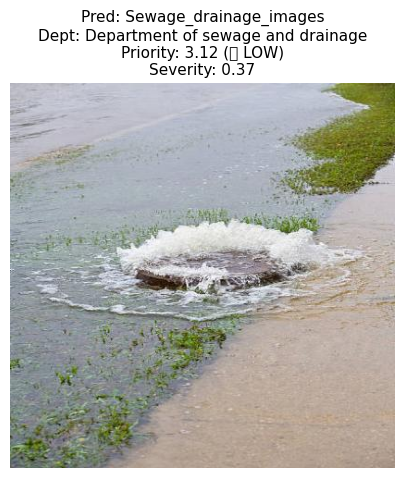


📷 gettyimages-157404693-612x612-1_jpg.rf.db451d12226806240632392193e97f78.jpg
   Predicted: Sewage_drainage_images  | Dept: Department of sewage and drainage  | Conf: 82.01%
   Severity: 0.37/10  | Freq: 9.35/10  | Recency: 6.00/10
   ➜ Priority: 3.12  [📝 LOW]


In [32]:
results = upload_and_score_images(show_images=True)

Saving 4c3d9cb0-6799-11e5-8dc4-40f2e96c8ad8_jpg.rf.12d2223030c5728de0eb3d0df3915fd8.jpg to 4c3d9cb0-6799-11e5-8dc4-40f2e96c8ad8_jpg.rf.12d2223030c5728de0eb3d0df3915fd8.jpg


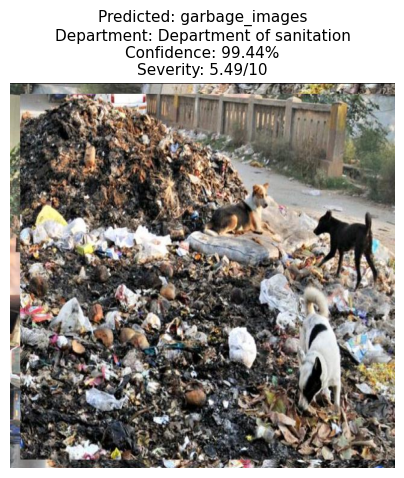

In [35]:
# === Show ALL parameters above each uploaded image (Class + Dept + Confidence + Severity) ===
from google.colab import files
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime

# --- safety checks (must exist from your training/priority cells) ---
for name in ("IMG_SIZE", "model", "classes", "PrioritySeverityAnalyzer"):
    if name not in globals():
        raise RuntimeError(f"{name} is not defined. Run your training + priority cells first.")

# Upload 1+ images
uploaded = files.upload()

# index -> class name
label_to_folder = {i: classes[i] for i in range(len(classes))}

# class name -> department (robust to case)
label_to_department = {
    'garbage_images': 'Department of sanitation',
    'Potholes_images': 'Department of Road and transport',
    'potholes_images': 'Department of Road and transport',
    'Sewage_drainage_images': 'Department of sewage and drainage',
    'sewage_drainage_images': 'Department of sewage and drainage',
    'street_light_images': 'Department of street light'
}

analyzer = PrioritySeverityAnalyzer()

def predict_image_with_severity(path):
    # ---- classification ----
    img = Image.open(path).convert('RGB').resize(IMG_SIZE)
    arr = np.array(img).astype(np.float32)
    arr = tf.keras.applications.efficientnet.preprocess_input(arr)
    arr = np.expand_dims(arr, 0)

    probs = model.predict(arr, verbose=0)[0]
    idx = int(np.argmax(probs))
    pred_label = label_to_folder[idx]
    dept = (label_to_department.get(pred_label)
            or label_to_department.get(pred_label.lower())
            or 'Department of sanitation')
    conf = float(probs[idx])

    # ---- severity (uses predicted label) ----
    severity = float(analyzer.analyze(pred_label, path, datetime.datetime.now()))

    return pred_label, dept, conf, severity

# ---- visualize each uploaded image with parameters in the title ----
for fn in uploaded.keys():
    pred_label, dept, conf, severity = predict_image_with_severity(fn)

    img = Image.open(fn).convert('RGB')
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis('off')
    title = (f"Predicted: {pred_label}\n"
             f"Department: {dept}\n"
             f"Confidence: {conf*100:.2f}%\n"
             f"Severity: {severity:.2f}/10")
    plt.title(title, fontsize=11)
    plt.show()
